# Dynamic Asset Allocation Project

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# !pip install cplex
import cplex 

# !apt install coinor-libipopt-dev
# !pip install ipopt
import ipopt

/usr/local/lib/python3.7/dist-packages/ipopt/__init__.py:13: FutureWarning: The module has been renamed to 'cyipopt' from 'ipopt'. Please import using 'import cyipopt' and remove all uses of 'import ipopt' in your code as this will be deprecated in a future release.
  warnings.warn(msg, FutureWarning)


## Part 1. Implement portfolio re-balancing investment strategies 
 
| |Variable|Explanation| 
|-|-|-|
|Input|x_init|initial position|
| |cash_init|cash account before portfolio re-balancing|
|Output|x_optimal|current position|
|  |cash_optimal|cash account after portfolio re-balancing|


##### 1.1 “Buy and hold" strategy
hold initial portfolio for the entire investment horizon of 2 years 

In [2]:
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal

##### 1.2 "Equally weighted" portfolio strategy
asset weights are selected as $w^t_i=\frac{1}{n}$, where n is the number of assets. You may need to re-balance
your portfolio in each period as the number of shares $x^t_i$ changes even when $w^t_i=\frac{1}{n}$
stays the same in each period.  

In [3]:
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    
    w = np.array([1/N]*N) # portfolio weight (value)
    budget = np.dot(x_init,cur_prices) + cash_init 
    single_asset_budget = budget / N
    x_optimal = single_asset_budget / cur_prices 
         
    # new cash account  = (portfolio value + old cash account) - value bought - transaction cost
    transaction_cost = np.dot(abs(x_init - x_optimal),cur_prices) * 0.005
    cash_optimal = budget - np.sum(x_optimal * cur_prices) -  transaction_cost   
    
    # Rounding procedure ########################################################################
    if cash_optimal >= 0: # round down
        x_optimal = np.floor(x_optimal)  
        transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005
        cash_optimal = budget - np.sum(x_optimal * cur_prices) - transaction_cost 
 
    if cash_optimal < 0: # reduce position to make cash account >= 0 
        x_reduce = (abs(cash_optimal) * w)/ cur_prices # for asset i: cash/price => position 
        x_optimal = np.floor(x_optimal - x_reduce)
        transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005 # update x_optimal, cash_optimal
        cash_optimal = budget - np.sum(x_optimal * cur_prices) - transaction_cost 
        
    return x_optimal, cash_optimal

##### 1.3 "Minimum variance" portfolio strategy 
compute minimum variance portfolio for each period and re-balance accordingly.

\begin{equation}
\begin{array}{rl}
\displaystyle \min_{w} & w^TQw \\
s.t.&\sum_i w_i = 1\\
& w \geq 0
\end{array}
\end{equation}

In [4]:
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    
    cpx = cplex.Cplex()
    cpx.set_results_stream(None) # Disable CPLEX output to screen
    cpx.set_warning_stream(None)
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    c  = [0.0] * N # no linear part of objectives function 
    lb = [0.0] * N # lower bounds on variables
    ub = [1.0] * N # upper bounds on variables
    
    A = [] # constrian matrix A
    for k in range(N):
        A.append([[0],[1.0]])  
    
    # Add objective function, bounds on variables and constrains to CPLEX model
    var_names = ["w_%s" % i for i in range(1,N+1)]
    cpx.linear_constraints.add(rhs=[1], senses="E")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    # define and add quadratic part of objective function 
    Qmat = [[list(range(N)), list(2*Q[k,:])] for k in range(N)]
    cpx.objective.set_quadratic(Qmat)
    
    # solve optimal portfolio weights
    cpx.solve()
    w = np.array(cpx.solution.get_values())
    
    budget = np.dot(x_init,cur_prices) + cash_init
    x_optimal = (budget * w) / cur_prices 
    
    # new cash account  = (portfolio value + old cash account) - value bought - transaction cost
    transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005
    cash_optimal = budget - np.sum(x_optimal * cur_prices) - transaction_cost 
    
    # Rounding procedure ########################################################################
    if cash_optimal >= 0: # round down
        x_optimal = np.floor(x_optimal)  
        transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005
        cash_optimal = budget - np.sum(x_optimal * cur_prices) - transaction_cost 
 
    if cash_optimal < 0: # reduce position to make cash account >= 0 
        x_reduce = (abs(cash_optimal) * w)/ cur_prices # for asset i: cash/price => position 
        x_optimal = np.floor(x_optimal - x_reduce)
        transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005 # update x_optimal, cash_optimal
        cash_optimal = budget - np.sum(x_optimal * cur_prices) - transaction_cost 
        
    return x_optimal, cash_optimal

##### 1.4 "Maximum Sharpe ratio" portfolio strategy
compute a portfolio that maximizes Sharpe ratio for each period and re-balance accordingly

\begin{equation}
\begin{array}{rl}
\displaystyle \min_{y \in R^n, k \in R} & y^TQy \\
s.t. &\sum_i (\mu_i - rf)y_i = 1\\
&\sum_i y_i = k\\
& lk \leq Ay \leq uk\\
& k \geq 0
\end{array}
\end{equation}

In [5]:
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    
    if sum(mu < 0) != 20:
        # r_rf = 0.025
        daily_rf =  r_rf / 252

        cpx = cplex.Cplex()
        cpx.set_results_stream(None) # Disable CPLEX output to screen
        cpx.set_warning_stream(None)
        cpx.objective.set_sense(cpx.objective.sense.minimize)

        c  = [0.0] * (N+1) # no linear part of objectives function 
        lb = [0.0] * (N+1) # lower bounds on variables
        ub = [np.inf] * (N+1) # upper bounds on variables

        A = [] # constrian matrix A
        for k in range(N):
            A.append([[0,1],[(mu - daily_rf)[k]]+[1]])  
        A.append([[0,1],[0,-1]])

        # Add objective function, bounds on variables and constrains to CPLEX model
        var_names = ["y_%s" % i for i in range(1,N+1)] + ["k"]
        cpx.linear_constraints.add(rhs=[1,0], senses="EE")
        cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)

        # define and add quadratic part of objective function 
        Qmat = [[list(range(N+1)), list(2*Q[k,:])+ [0]] for k in range(N)]
        Qmat.append([list(range(N+1)), list(21 *[0])])
        cpx.objective.set_quadratic(Qmat)

        # solve optimal portfolio weights
        cpx.solve()
        x = np.array(cpx.solution.get_values())
        w = np.array(np.divide(x[0:N],x[N]))

        budget = np.dot(x_init,cur_prices) + cash_init
        x_optimal = (budget * w) / cur_prices 

        # new cash account  = (portfolio value + old cash account) - value bought - transaction cost
        transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005
        cash_optimal = budget - np.sum(x_optimal * cur_prices) - transaction_cost 

        # Rounding procedure ########################################################################
        if cash_optimal >= 0: # round down
            x_optimal = np.floor(x_optimal)  
            transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005
            cash_optimal = budget - np.sum(x_optimal * cur_prices) - transaction_cost 

        if cash_optimal < 0: # reduce position to make cash account >= 0 
            x_reduce = (abs(cash_optimal) * w)/ cur_prices # for asset i: cash/price => position 
            x_optimal = np.floor(x_optimal - x_reduce)
            transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005 # update x_optimal, cash_optimal
            cash_optimal = budget - np.sum(x_optimal * cur_prices) - transaction_cost 
    else:
        x_optimal = x_init
        cash_optimal = cash_init
        
    return x_optimal, cash_optimal

##### 1.5 "Equal risk contributions" portfolio strategy
\begin{equation}
\begin{array}{rl}
\displaystyle \min_{w} & \sum_{i=1}^n \sum_{j=1}^n (w_i(Qw)_i - w_j(Qw)_j)^2\\
s.t. &\sum_i^{n} w_i = 1\\
& w_i \geq 0\\ 
\end{array}
\end{equation}



In [6]:
class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(N):
            for j in range(i,N):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        # The callback for calculating the gradient
        grad = np.zeros(N)
        
        # Insert your gradient computations here
        y = x * np.dot(Q, x)
        for i in range(N):
            fval = 0
            for j in range(i,N):
                xij = y[i] - y[j]
                fval = fval + xij
            grad[i] = 8 * fval * np.dot(Q, x)[i]
        return grad
    
    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * N
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * N])

#     def intermediate(
#             self,
#             alg_mod,
#             iter_count,
#             obj_value,
#             inf_pr,
#             inf_du,
#             mu,
#             d_norm,
#             regularization_size,
#             alpha_du,
#             alpha_pr,
#             ls_trials
#             ):

#         # Example for the use of the intermediate callback.
#          print("Objective value at iteration #%d is - %g" % (iter_count, obj_value))

In [7]:
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    
    w0 = [1.0/N] * N # Use "1/n portfolio" w0 as initial portfolio for starting IPOPT optimization

    lb = [0.0] * N  # lower bounds on variables
    ub = [1.0] * N  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
 
    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)

    # Solve optimal portfolio weights
    n = N
    w, info = nlp.solve(w0)
    
    money_owned = np.dot(x_init,cur_prices) + cash_init
    x_optimal = (money_owned * w)/ cur_prices 
  
    # new cash account  = (portfolio value + old cash account) - value bought - transaction cost
    transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005
    cash_optimal = money_owned - np.dot(x_optimal,cur_prices) - transaction_cost 
     

    # Rounding procedure ########################################################################
    if cash_optimal >= 0: # round down
        x_optimal = np.floor(x_optimal)  
        transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005
        cash_optimal = money_owned - np.sum(x_optimal * cur_prices) - transaction_cost 
 
    if cash_optimal < 0: # reduce position to make cash account >= 0 
        x_reduce = (abs(cash_optimal) * w)/ cur_prices # for asset i: cash/price => position 
        x_optimal = np.floor(x_optimal - x_reduce)
        transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005 # update x_optimal, cash_optimal
        cash_optimal = money_owned - np.sum(x_optimal * cur_prices) - transaction_cost 
    
    return x_optimal, cash_optimal

##### 1.6 "Leveraged equal risk contributions" portfolio strategy

In [8]:
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):

    w0 = [1.0/N] * N # Use "1/n portfolio" w0 as initial portfolio for starting IPOPT optimization

    lb = [0.0] * N  # lower bounds on variables
    ub = [1.0] * N  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
 
    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)

    # Solve optimal portfolio weights
    w, info = nlp.solve(w0)
    
    # long 200% position, double portfolios
    borrowed_money = np.dot(x_init,cur_prices) + cash_init 
    money_owned = np.dot(x_init,cur_prices) + cash_init + borrowed_money
    x_optimal = (money_owned * w) / cur_prices 

    # new cash account  = (portfolio value + old cash account) - value bought - transaction cost  
    transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005
    
    cash_optimal = money_owned - np.dot(x_optimal,cur_prices) - transaction_cost   

    # Rounding procedure ########################################################################
    if cash_optimal >= 0: # round down
        x_optimal = np.floor(x_optimal)  
        transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005
        cash_optimal = money_owned - np.dot(x_optimal,cur_prices) - transaction_cost 
 
    if cash_optimal < 0: # reduce position to make cash account >= 0 
        x_reduce = (abs(cash_optimal) * w)/ cur_prices # for asset i: cash/price => position 
        x_optimal = np.floor(x_optimal - x_reduce)
        transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005 # update x_optimal, cash_optimal
        cash_optimal = money_owned - np.dot(x_optimal,cur_prices) - transaction_cost  
    
    # manually check whether cash account is negative before return borrowed money 
    # print (cash_optimal)
    
    # return borrowed_money
    liability = borrowed_money * (1+0.025/6)
    cash_optimal = cash_optimal -  liability
    return x_optimal, cash_optimal

##### 1.7 "Robust mean-variance optimization" portfolio strategy

\begin{equation}
\begin{array}{rl}
\displaystyle \min_{w} & w^TQw\\
s.t. &\sum_i^{n} w_i = 1\\
& w_i \geq 0\\ 
& \mu^Tw \geq \epsilon_{ret}\\ 
& w^T \Theta w \leq \epsilon_{rob}\\ 
\end{array}
\end{equation}

In [9]:
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
 
    # Target risk estimation error: var of 1/n portfolio ####################################
    w0 = [1.0/N] * N
    var_matr = np.diag(np.diag(Q))
    rob_init = np.dot(w0, np.dot(var_matr, w0)) # return estimation error of initial portfolio
    rob_bnd  = rob_init # target return estimation error
    
    
    # Target return: return of MVP ####################################
    cpx = cplex.Cplex()
    cpx.set_results_stream(None) # Disable CPLEX output to screen
    cpx.set_warning_stream(None)
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    c  = [0.0] * N # no linear part of objectives function 
    lb = [0.0] * N # lower bounds on variables
    ub = [1.0] * N # upper bounds on variables
    
    A = [] # constrian matrix A
    for k in range(N):
        A.append([[0],[1.0]])  
    
    # Add objective function, bounds on variables and constrains to CPLEX model
    var_names = ["w_%s" % i for i in range(1,N+1)]
    cpx.linear_constraints.add(rhs=[1], senses="E")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    # define and add quadratic part of objective function 
    Qmat = [[list(range(N)), list(2*Q[k,:])] for k in range(N)]
    cpx.objective.set_quadratic(Qmat)
    
    # solve optimal portfolio weights
    cpx.solve()
    w_minVar = np.array(cpx.solution.get_values())
    ret_minVar = np.dot(mu, w_minVar)
    Portf_Retn = ret_minVar
  
    
    # Robust mean-variance ############################################
    cpx = cplex.Cplex()
    cpx.set_results_stream(None) # Disable CPLEX output to screen
    cpx.set_warning_stream(None)
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    c  = [0.0] * N # no linear part of objectives function 
    lb = [0.0] * N # lower bounds on variables
    ub = [1.0] * N # upper bounds on variables
    
    A = [] # constrian matrix A
    for k in range(N):
        A.append([[0,1],[1.0,mu[k]]])
     
    # Add objective function, bounds on variables and constrains to CPLEX model
    var_names = ["w_%s" % i for i in range(1,N+1)]
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    # define and add quadratic part of objective function 
    Qmat = [[list(range(N)), list(2*Q[k,:])] for k in range(N)]
    cpx.objective.set_quadratic(Qmat)
    
    # Add quadratic constraint on return estimation error 
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(N), val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    
    # solve optimal portfolio weights
    cpx.parameters.threads.set(4)
    cpx.parameters.timelimit.set(60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    cpx.solve()
    w = np.array(cpx.solution.get_values())

    
    budget = np.dot(x_init,cur_prices) + cash_init
    x_optimal = (budget * w) / cur_prices 
    
    # new cash account  = (portfolio value + old cash account) - value bought - transaction cost
    transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005
    cash_optimal = budget - np.sum(x_optimal * cur_prices) - transaction_cost 
    
    # Rounding procedure ########################################################################
    if cash_optimal >= 0: # round down
        x_optimal = np.floor(x_optimal)  
        transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005
        cash_optimal = budget - np.sum(x_optimal * cur_prices) - transaction_cost 
 
    if cash_optimal < 0: # reduce position to make cash account >= 0 
        x_reduce = (abs(cash_optimal) * w)/ cur_prices # for asset i: cash/price => position 
        x_optimal = np.floor(x_optimal - x_reduce)
        transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005 # update x_optimal, cash_optimal
        cash_optimal = budget - np.sum(x_optimal * cur_prices) - transaction_cost 
        
    return x_optimal, cash_optimal

##### 1.8 Try a different portfolio strategie

In [10]:
def new_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    # Input) x_init: initial position/ cash_init: cash account before portfolio re-balancing
    # Output) x_optimal: current position/ cash_optimal: cash account after portfolio re-balancing

    portfolio_value = np.dot(x_init,cur_prices) + cash_init 
    x_optimal =  (1000000/20) / data_prices[0]
    transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005
    # new cash account  = value sold + old cash account - value bought - transaction cost
    cash_optimal = portfolio_value - np.sum(x_optimal * cur_prices) - transaction_cost  
   
    # rounding procedure    
    if cash_optimal >= 0:
        x_optimal = np.ceil(x_optimal)
        transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005
        cash_optimal = portfolio_value - np.sum(x_optimal * cur_prices) - transaction_cost 
    
    while cash_optimal < 0: #(cash account must be nonnegative)  
        # update x_optimal, transaction_cost & cash_optimal
        x_optimal = np.array(list(map(lambda x: np.ceil(x * (1-0.0005)), x_optimal)))
        transaction_cost = np.dot(abs(x_optimal-x_init),cur_prices) * 0.005
        cash_optimal = portfolio_value - np.sum(x_optimal * cur_prices) - transaction_cost
        
    return x_optimal, cash_optimal

## Part 2. Analyze results (2019 - 2020)
 

In [11]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)
df

,Date,MSFT,F,JPM,GOOG,HPQ,C,HOG,VZ,AAPL,IBM,T,CSCO,BAC,INTC,AMD,SNE,NVDA,AMZN,MS,BK
0,11/01/2018,102.838272,8.565945,101.248016,1070.000000,22.670326,61.106766,36.744102,50.974819,54.075333,104.595551,26.381783,42.575386,26.334023,45.617783,20.219999,55.660000,216.686752,1665.530029,43.292477,44.903912
1,11/02/2018,103.071304,8.648931,100.690582,1057.790039,22.799921,61.611465,37.221058,51.502300,50.488487,103.557014,26.407740,42.416840,26.409775,44.567680,20.230000,53.660000,213.517593,1665.530029,43.349087,44.610977
2,11/05/2018,104.382019,8.787239,101.350204,1040.089966,22.809179,62.901272,36.669289,52.029785,49.055202,107.487297,26.502918,43.032391,26.570753,45.381268,19.900000,53.320000,210.388168,1627.800049,43.226440,45.329136
3,11/06/2018,104.585907,8.796461,101.824020,1055.810059,23.031343,62.321796,36.949844,52.029785,49.585682,110.226868,26.788452,43.368137,26.712791,44.981434,20.680000,53.500000,209.682785,1642.810059,43.132099,45.659870
4,11/07/2018,108.702545,8.851785,103.570641,1093.390015,23.577505,63.798527,38.305897,52.429947,51.089535,111.766747,26.909588,44.673847,27.025278,46.380856,21.840000,55.259998,212.394974,1755.489990,43.971729,46.085094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,12/24/2020,222.750000,8.860000,123.629646,1738.849976,24.260000,60.570000,37.110001,58.216766,131.970001,124.690002,28.191212,44.181690,29.959999,47.070000,91.809998,96.839996,519.750000,3172.689941,68.089996,41.040001
541,12/28/2020,224.960007,8.890000,124.443787,1776.089966,24.270000,61.130001,37.099998,58.355286,136.690002,124.820000,28.053644,44.558628,30.129999,47.070000,91.599998,97.949997,516.000000,3283.959961,68.050003,41.439999
542,12/29/2020,224.149994,8.820000,124.116150,1758.719971,24.049999,60.910000,36.459999,58.187088,134.869995,123.800003,28.043819,44.280884,30.010000,49.389999,90.620003,100.430000,517.729980,3322.000000,67.709999,41.439999
543,12/30/2020,221.679993,8.860000,124.463646,1739.520020,24.320000,60.860001,37.009998,57.524181,133.720001,124.339996,27.994688,44.122169,29.980000,48.750000,92.290001,100.779999,525.830017,3285.850098,67.839996,41.689999


In [12]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

# Find the number of trading days in Nov-Dec 2018  
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2018)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1

In [13]:
# Remove datapoints for year 2018
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

In [14]:
# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20000])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value


Initial portfolio value = $ 1000070.06



In [15]:
# Compute expected return and covariance matrix for period 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Annual risk-free rate for years 2019-2020 is 2.5%
r_rf = 0.025

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

##### Compute portfolio values at the first and last trading days  


In [16]:
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 
                      'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim', ]
strategy_names = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 
                  'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 
                  'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, 
            strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

for period in range(1, N_periods+1): # 1- 12
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 19:
        cur_year  = 19 + math.floor(period/7)
    else:
        cur_year  = 2019 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy in range(N_strat):
        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]
 
        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
        
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0  
        # Check that we can buy new portfolio subject to transaction costs
        if strategy != 5: # manully check 'Leveraged Equal Risk Contributions Portfolio' 
            if cash[strategy, period-1] < 0:
                print ('Strategy "{0}", cash account is negative'.format( strategy_names[strategy]))

        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
              portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      
    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)


Period 1: start date 01/02/2019, end date 02/28/2019
Strategy "Buy and Hold", value begin = $ 1000070.06, value end = $ 1121179.83
Strategy "Equally Weighted Portfolio", value begin = $ 991110.53, value end = $ 1097139.05
Strategy "Minimum Variance Portfolio", value begin = $ 991694.21, value end = $ 1057724.38
Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990119.39, value end = $ 1016524.41
Strategy "Equal Risk Contributions Portfolio", value begin = $ 991350.69, value end = $ 1086730.66
Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 983446.28, value end = $ 1174676.92


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The class named 'problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'Problem' going forward.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/cyipopt/utils.py:43: FutureWarning: The method named 'addOption' in class 'Problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'add_option' going forward.
  warnings.warn(msg, FutureWarning)


Strategy "Robust Optimization Portfolio", value begin = $ 992339.32, value end = $ 1074547.25

Period 2: start date 03/01/2019, end date 04/30/2019
Strategy "Buy and Hold", value begin = $ 1126131.27, value end = $ 1075001.89
Strategy "Equally Weighted Portfolio", value begin = $ 1103425.44, value end = $ 1188889.41
Strategy "Minimum Variance Portfolio", value begin = $ 1055665.23, value end = $ 1108286.33
Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1007117.74, value end = $ 1076765.61
Strategy "Equal Risk Contributions Portfolio", value begin = $ 1090630.16, value end = $ 1157845.60
Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 1177450.15, value end = $ 1323589.17
Strategy "Robust Optimization Portfolio", value begin = $ 1074340.83, value end = $ 1122847.09

Period 3: start date 05/01/2019, end date 06/28/2019
Strategy "Buy and Hold", value begin = $ 1070867.54, value end = $ 969057.81
Strategy "Equally Weighted Portfolio", value begin = $ 118

##### Plot

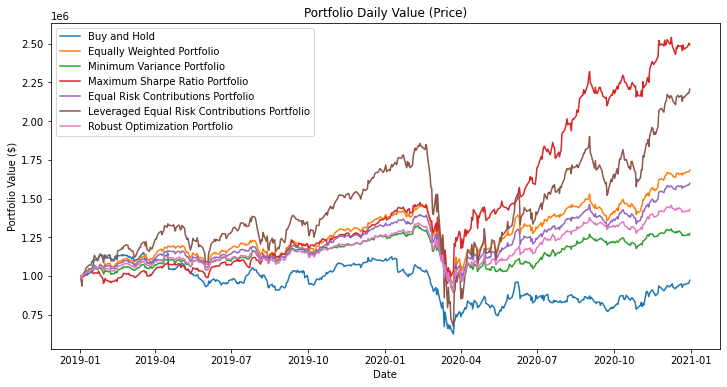

In [17]:
# Plot daily value of portfolio using daily prices provided

fig, ax = plt.subplots(figsize=(12, 6))
for i in range(N_strat):
    ax.plot(pd.to_datetime(dates),portf_value[i], label =strategy_names[i])
    
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Daily Value (Price)')
plt.legend()
plt.show()

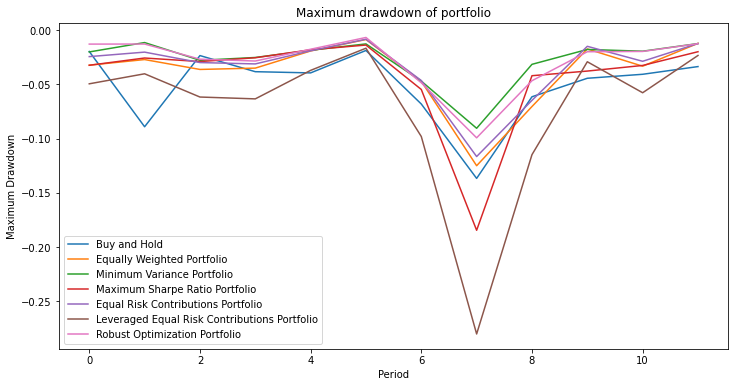

In [18]:
# Plot that illustrate Maximum drawdown of portfolio for each of the 12 periods  

portfolio_value = pd.DataFrame(index =pd.to_datetime(dates)) 
for i in range (N_strat):
    portfolio_value [strategy_names[i]] = portf_value[i]

portfolio_change = portfolio_value.pct_change()
max_drawdown = pd.DataFrame() 
period_start =  [0,40,82,124,168,211,252,292,335,377,420,463,505]
for i in range(12):
    start = period_start[i]
    end = period_start[i+1]
    period_max_drawdown = pd.DataFrame(portfolio_change.iloc[start:end,:].min()).T
    max_drawdown = max_drawdown.append(period_max_drawdown)

max_drawdown.index = range(12)
 
max_drawdown.plot(figsize=(12,6))
plt.xlabel('Period')
plt.ylabel('Maximum Drawdown')
plt.title("Maximum drawdown of portfolio")
plt.legend(loc='best')
plt.show()

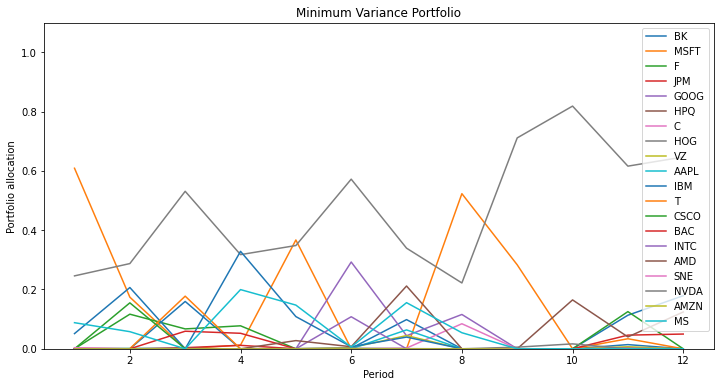

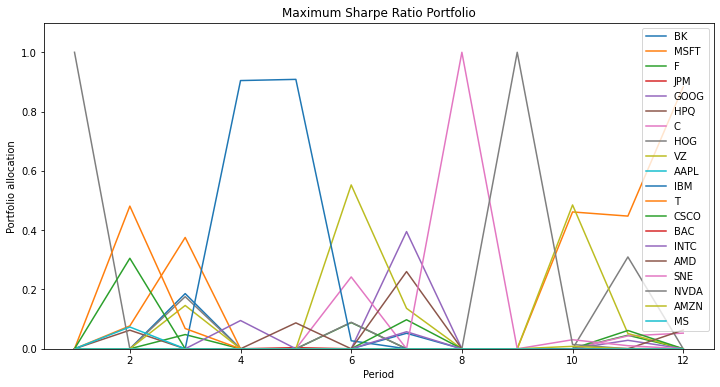

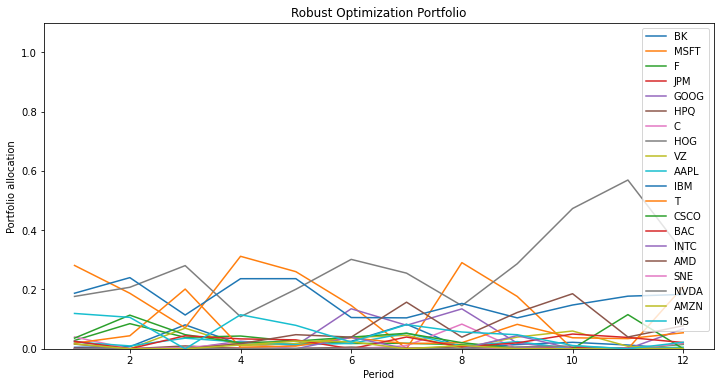

In [19]:
# Plot dynamic changes in portfolio allocations for strategy 3, 4 and 7

assets = list(df.columns[1:])
for strategy in [2,3,6]:
    fig, ax = plt.subplots(figsize=(12, 6))
    allocation = []
    for i in range(12):
        rebalance_position = x[strategy][i]/ sum(x[strategy][i])
        allocation.append(list(rebalance_position))

    allocation = pd.DataFrame(allocation)
    allocation.index = np.arange(1,13)

    for i in range(20):
        plt.plot(allocation[i],label=assets[i-1])

    plt.xlabel('Period')
    plt.ylim(0,1.1)
    plt.ylabel('Portfolio allocation')
    plt.title(strategy_names[strategy])
    plt.legend(loc='upper right')
    plt.show()
    

## Part 3. Analyze results (2008 - 2009)


##### Compute portfolio values at the first and last trading days

In [20]:
# Input file
input_file_prices = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)
df

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])

# Find the number of trading days in Nov-Dec 2007 and compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2007
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 980, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20000])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
r_rf = r_rf2008_2009

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Minimum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)

for period in range(1, N_periods+1): # 1- 12
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 8:
        cur_year  = 8 + math.floor(period/7)
    else:
        cur_year  = 2008 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy in range(N_strat):
        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]
 
        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0  
        # Check that we can buy new portfolio subject to transaction costs

        ###################### Insert your code here ############################
        if strategy != 5: # manully check 'Leveraged Equal Risk Contributions Portfolio' 
            if cash[strategy, period-1] < 0:
                print ('Strategy "{0}", cash account is negative'.format( strategy_names[strategy]))

        # Compute portfolio value
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
              portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      
    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)
 



Initial portfolio value = $ 789230.94


Period 1: start date 01/02/2008, end date 02/29/2008
Strategy "Buy and Hold", value begin = $ 789230.94, value end = $ 749509.71
Strategy "Equally Weighted Portfolio", value begin = $ 782158.10, value end = $ 669692.42
Strategy "Minimum Variance Portfolio", value begin = $ 781379.45, value end = $ 666830.57
Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 781378.15, value end = $ 681744.86
Strategy "Equal Risk Contributions Portfolio", value begin = $ 782129.34, value end = $ 674108.17
Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 775567.54, value end = $ 558995.70


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The class named 'problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'Problem' going forward.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/cyipopt/utils.py:43: FutureWarning: The method named 'addOption' in class 'Problem' will soon be deprecated in CyIpopt. Please replace all uses and use 'add_option' going forward.
  warnings.warn(msg, FutureWarning)


Strategy "Robust Optimization Portfolio", value begin = $ 782106.92, value end = $ 679233.31

Period 2: start date 03/03/2008, end date 04/30/2008
Strategy "Buy and Hold", value begin = $ 754361.26, value end = $ 752687.89
Strategy "Equally Weighted Portfolio", value begin = $ 659705.67, value end = $ 726740.28
Strategy "Minimum Variance Portfolio", value begin = $ 657758.18, value end = $ 745536.40
Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 667671.09, value end = $ 705483.22
Strategy "Equal Risk Contributions Portfolio", value begin = $ 664197.28, value end = $ 739831.98
Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 536648.31, value end = $ 659706.17
Strategy "Robust Optimization Portfolio", value begin = $ 670983.29, value end = $ 740768.66

Period 3: start date 05/01/2008, end date 06/30/2008
Strategy "Buy and Hold", value begin = $ 779329.50, value end = $ 663602.44
Strategy "Equally Weighted Portfolio", value begin = $ 750503.35, value en

##### Plot

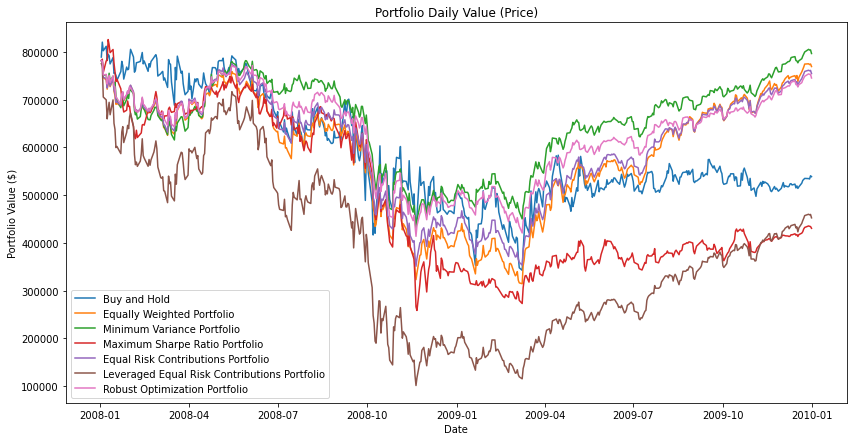

In [21]:
# Plot daily value of portfolio using daily prices provided

fig, ax = plt.subplots(figsize=(14, 7))
for i in range(N_strat):
    ax.plot(pd.to_datetime(dates),portf_value[i], label =strategy_names[i])
    
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Daily Value (Price)')
plt.legend()
plt.show()



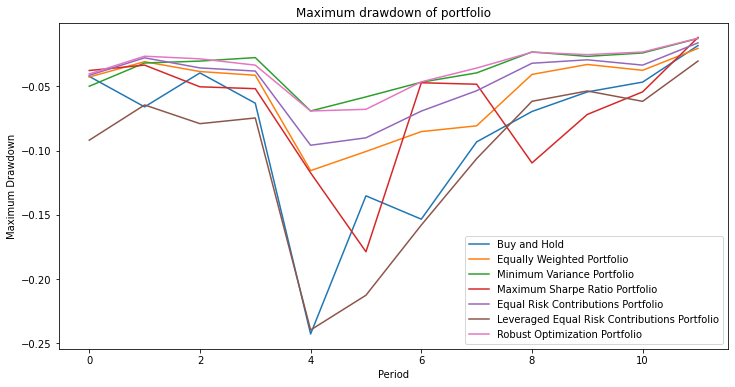

In [22]:
# Plot that illustrate Maximum drawdown of portfolio for each of the 12 periods  

portfolio_value = pd.DataFrame(index =pd.to_datetime(dates)) 
for i in range (N_strat):
    portfolio_value [strategy_names[i]] = portf_value[i]

portfolio_change = portfolio_value.pct_change()
max_drawdown = pd.DataFrame() 
period_start =  [0,40,82,124,168,211,252,292,335,377,420,463,505]
for i in range(12):
    start = period_start[i]
    end = period_start[i+1]
    period_max_drawdown = pd.DataFrame(portfolio_change.iloc[start:end,:].min()).T
    max_drawdown = max_drawdown.append(period_max_drawdown)

max_drawdown.index = range(12)
 
max_drawdown.plot(figsize=(12,6))
plt.xlabel('Period')
plt.ylabel('Maximum Drawdown')
plt.title("Maximum drawdown of portfolio")
plt.legend(loc='best')
plt.show()

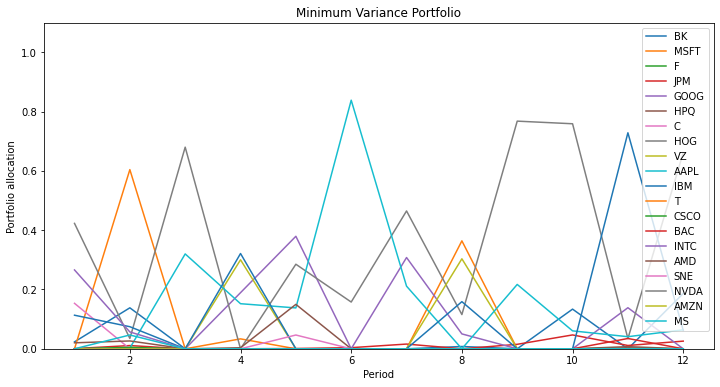

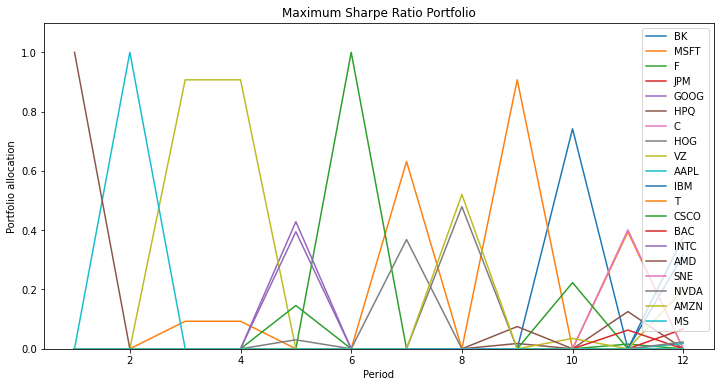

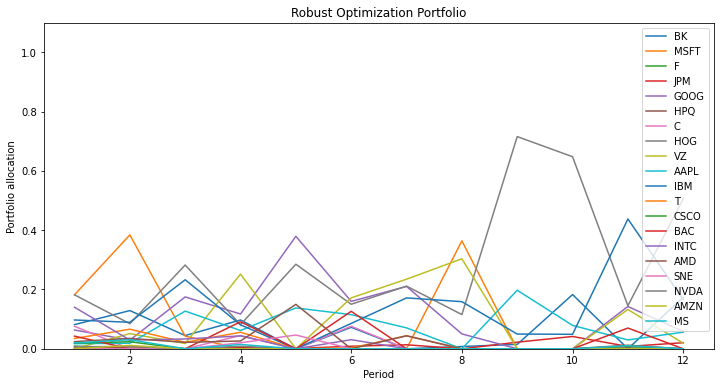

In [23]:
# Plot dynamic changes in portfolio allocations for strategy 3, 4 and 7

assets = list(df.columns[1:])
for strategy in [2,3,6]:
    fig, ax = plt.subplots(figsize=(12, 6))
    allocation = []
    for i in range(12):
        rebalance_position = x[strategy][i]/ sum(x[strategy][i])
        allocation.append(list(rebalance_position))

    allocation = pd.DataFrame(allocation)
    allocation.index = np.arange(1,13)

    for i in range(20):
        plt.plot(allocation[i],label=assets[i-1])

    plt.xlabel('Period')
    plt.ylim(0,1.1)
    plt.ylabel('Portfolio allocation')
    plt.title(strategy_names[strategy])
    plt.legend(loc='upper right')
    plt.show()